# "Accelerated ODE Inference with PyDEns and PyMC3"
> "An introduction to training neural networks to solve parametric families of ODEs with PyDEns + using PyMC3 to sample the posterior."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jonathan Lindbloom
- hide: true

# !!! This is a work-in-progress !!!

# Traditional Approaches

As a newcommer to the PyMC3 community about a year ago, one of the things I was most excited to learn about was using PyMC3 to perform Bayesian inference for systems of ordinary differential equations (ODEs). In order to take advantage of the efficiency of the NUTS sampler you must be able to provide gradients of the model with respect to each of the model parameters, which can be tricky for ODEs. In my experiences, ignoring the case in which you happen to know the analytic solution there seems to be three approaches to achieving this:

1. Write an ODE solver entirely in Theano which automatically gives you ability to get gradients via autodiff. This might seem like the easiest way to get the gradients, but you lose the confidence provided by well-tested solvers and it is hard to control the errors in the calculated gradients. 
2. Use an ODE solver coupled with the [adjoint method](https://en.wikipedia.org/wiki/Adjoint_state_method) to get the gradients by solving an associated system of ODEs. This is what is done in the package [sunode](https://github.com/aseyboldt/sunode).
3. Use an ODE solver coupled with local sensitivity analysis to get the gradients by solving an augmented system of ODEs. This is the approach taken in the PyMC3 example on the [Lotka-Volterra model with manual gradients](https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_with_manual_gradients.html).

However, you may have noticed that sometimes these methods can be slow. Let's take a look at what might cause this. Suppose we are given some parametric ODE system $$ \frac{d\mathbf{x}}{dt} = f(\mathbf{x}, t; \theta) $$ with an initial condition $\mathbf{x}_0$ and would like to know both $\mathbf{x}(T)$ and $\frac{\partial \mathbf{x}(T)}{\partial \theta}$  for some later time $T > 0$. Traditional methods for approximating $\mathbf{x}(T)$ boil down to computing a sequence of points $\{ (t_j, \mathbf{x}^{j}) \}_{j=0}^{M}$ with the goal being that $\mathbf{x}^M \approx \mathbf{x}(T)$. We might compute this sequence using the [Euler method](https://en.wikipedia.org/wiki/Euler_method#:~:text=The%20Euler%20method%20is%20a,proportional%20to%20the%20step%20size.) or better yet a [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). If we want to increase the accuracy of our approximation $\mathbf{x}^M \approx \mathbf{x}(T)$ we can decrease the timestep of our method which consequently lengthens the sequence of intermediary points we must compute. If all we care about is getting $\mathbf{x}^M$ correct and won't use the other points $\{ \mathbf{x}^{j}\}_{j=0}^{M-1}$ for anything, we end up computing an awfully large amount of intermediary points we don't actually care about. Now you might point out that in practice we often get a whole time-series of observations and that actually we *will* be using many of these intermediary points. OK, fine. But what if our desired numerical accuracy of our solver requires a timestep that makes our observations sparse in time when compared to the granularity of our approximating sequence? This is effectively the same dilemma as before &mdash; we approximate the solution of the ODE at a ton of times that we don't actually care about it. Inference with ODEs using these methods can be slow since each step of MCMC must re-calculate these lengthy sequences of points for a different set of parameters $\theta$. If we want to speed up ODE inference, it seems like our time would be well-spent trying to avoid the calculation of these sequences at each step. The goal of this post is to introduce a new and exciting alternative to achieve this!

# An Outline of the Neural Network Approach


The neural network approach to inference for ODEs involves an expensive *offline* step that then permits lightning-fast *online* inference. By *offline*, I mean that we can offload the computational expense associated with approximating ODE solutions during inference by pre-computing entire families of solutions in advance. But rather than building up a database of ODE solutions calculated from some traditional solver and then querying/interpolating from that, we instead use a neural network to encode this information. Miraculously, training this neural network *requires no reference solutions* to learn from. This offline step might end up being more costly on net for a given tolerance than if we were to just approximate the ODE solution with some traditional solver, but the point is that this approach allows us to pay this cost upfront instead of gradually over the course of an inference algorithm like MCMC. This approach will also allow us to circumvent the aforementioned burden of having to compute solutions and gradients for intermediary time points between our observations each time we query a solution of the ODE. An extra benefit is that if we want to fit the same ODE to many different sets of data, we can just save and reload our neural network instead of incurring the cost of the expensive offline step each time.


# Thinking Differently About Differential Equations

A concept we need to introduce before we dive in is the *flow map* associated to an autonomous ODE. Suppose that we know we start at $\mathbf{x}_0 \in \mathbb{R}^d$ and want to know where in the phase space we'll be at time $t = \tau$. The *flow map* $\Phi_\tau : \mathbb{R}^d \to \mathbb{R}^d$ is the function that takes us from $\mathbb{x}_0$ directly to $\mathbb{x}(\tau)$, as well as from any other possible initial condition $\mathbb{x}_0'$ we could've chosen to where it would be at time $t = \tau$. In other words, 
$$ \Phi_\tau(\mathbb{x}_0) = \mathbb{x}(\tau) $$ where $\mathbb{x}(t)$ is the solution to the initial value problem
$$
\begin{align}
      \cfrac{d \mathbb{x}}{dt} &= f(\mathbb{x}; \theta) & \text{for $t \in [0, \tau]$}\\
      \mathbb{x}(0) &= \mathbb{x}_0     
\end{align}
$$
If we knew the flow map $\Phi_\tau$ for any $\mathbb{x}_0 \in \mathbb{R}^d$ and $\tau > 0$ then we wouldn't have to bother with calculating an approximating sequence with a traditional solver in order to approximate $\mathbb{x}(T)$ &mdash; we could just evaluate $\Phi_T(\mathbb{x}_0) = \mathbb{x}(T)$. If we also knew $\frac{\partial \Phi_\tau}{\partial \theta}$, the gradient of the flow map with respect to the ODE parameters, we would have all of the requisite information we need to then proceed with using a gradient-based sampler like NUTS. This is all much easier said than done, but we will proceed with trying to approximate $\Phi_\tau$ and $\frac{\partial \Phi_\tau}{\partial \theta}$.


# Using Neural Networks to Solve ODEs

If you're reading this post and don't know much about neural networks, don't worry &mdash; I'm no expert either. In this post, a "neural network" simply refers to some function $F_{\mathcal{\eta}} : \mathbb{R}^{d_1} \to \mathbb{R}^{d_2}$ where $\eta$ represents some set of trainable parameters (treat these completely separate from our model parameters $\theta$). By "trainable" I mean that we can tweak $\eta$ in order to get $F_\eta$ to "agree" with some other function $G: \mathbb{R}^d \to \mathbb{R}^d$, and by "agree" I mean that given some set of points $ P \subset \mathbb{R}^{d_1} $ we can tweak $\eta$ to get $F_\eta(\mathbb{x}) \approx G(\mathbb{x})$ for $\mathbb{x} \in P$. Recall that the flow map $\Phi_\tau$ we introduced was a function $\Phi_\tau: \mathbb{R}^d \to \mathbb{R}^d$. Let's define a new function $\Phi$ by moving $\tau$ out of the subscript such that $\Phi(\mathbb{x}_0, \tau) = \Phi_\tau(\mathbb{x}_0)$. Now we have a function $\Phi: \mathbb{R}^{d+1} \to \mathbb{R}^d$. Earlier we restricted our discussion to just autonomous ODEs, but what we're about to do applies to non-autonomous ODEs as well. What if we took $d_1 = d+1$, $d_2=d$, and then tried to train $F_\eta$ to agree with $\Phi$?

Enter [PyDEns](https://github.com/analysiscenter/pydens), a Python package for solving ODEs (and PDEs) with neural networks that does just this. I will not go into the specifics here of how to use PyDEns or the theory of what is going on under the hood since the PyDEns developers provide an excellent series of tutorial notebooks [here](https://github.com/analysiscenter/pydens/blob/master/tutorials/0.%20Theory.ipynb). Perhaps it's best to start with an example of PyDEns in action.
$$
\cfrac{dx}{dt} = \cos(t)
$$
with some initial condition $x(0) = x_0$, for which we know that the analytic solution is
$$
x(t) = \sin(t) + x_0.
$$
Ignoring the specifics of what's going on down below, let's fix $x_0 = 0$ and use PyDEns to train a neural network that solves this ODE.

In [3]:
#collapse
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tqdm import tqdm_notebook

import tensorflow as tf
from pydens import Solver, NumpySampler, cart_prod, add_tokens
from pydens import plot_loss, plot_pair_1d, plot_2d, plot_sections_2d, plot_sections_3d

import numpy as np
import matplotlib.pyplot as plt

add_tokens()

In [4]:
#hide

import matplotlib as mpl
plt.style.use('dark_background')
mpl.rcParams['axes.facecolor'] = '#010E1A'
mpl.rcParams['figure.facecolor'] = '#010E1A'
mpl.rcParams['figure.edgecolor'] = '#010E1A'
mpl.rcParams.update({
    "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Palatino"],
})

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

In [5]:
ode = {
    'n_dims': 1,
    'form': lambda u, t : D(u, t) - cos(t), 
    'initial_condition': 0.0,
}

config = {
    'pde': ode,
}

dg = Solver(config)

sampler = NumpySampler('uniform', dim=1, low=0.0, high=10.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=100000, bar="notebook")

  0%|          | 0/100000 [00:00<?, ?it/s]

That looks like it did something exciting! Let's look at the solution that our neural network predicts.

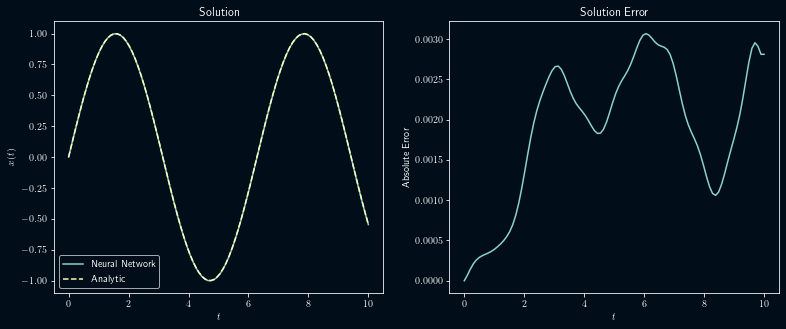

In [6]:
#collapse

t = np.linspace(0, 10, 100)

# Get the NN solution
t_reshaped = t[:, None]
nn_sol = dg.solve(t_reshaped)[:,0]

# Get the analytic solution
analytic_sol = np.sin(t)

# Get the error
error = np.abs(analytic_sol - nn_sol)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(13,5))

# The solutions
axs[0].plot(t, nn_sol, label="Neural Network")
axs[0].plot(t, analytic_sol, label="Analytic", linestyle="--")
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel(r"$x(t)$")
axs[0].set_title("Solution")
axs[0].legend()

# The error
axs[1].plot(t, error)
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("Absolute Error")
axs[1].set_title("Solution Error")

plt.show()


That looks pretty accurate! Perhaps you're unimpressed since all we did was learn a simple sine curve, so let's try to learn to solve an entire parametric family of ODEs by adding a parameter to this ODE
$$
\cfrac{dx}{dt} = \alpha \cos(t) 
$$
with fixed $x_0 = 0$. The analytic solution for this ODE is just
$$
x(t) = \alpha \sin(t) + x_0.
$$
 One feature of this approach is that we must specify the range of values we would like to train the parameters over. In this example, we'll train the neural network to solve the ODE for $\alpha \in [-3, 3]$.

In [7]:
ode = {
    'n_dims': 1,
    'form': lambda u, t, alpha : D(u, t) - P(alpha)*cos(t), 
    'initial_condition': 0.0,
}

config = {
    'pde': ode,
    'track': {'dxdalpha': lambda u, t, alpha: D(u, alpha)}
}

dg = Solver(config)

sampler = NumpySampler('uniform', low=0.0, high=10.0) & NumpySampler('uniform', low=-2.2, high=2.2)
dg.fit(batch_size=50, sampler=sampler, n_iters=200000, bar="notebook")

  0%|          | 0/200000 [00:00<?, ?it/s]

Now let's ask our neural network to predict the solutions given several different values of $\alpha$.

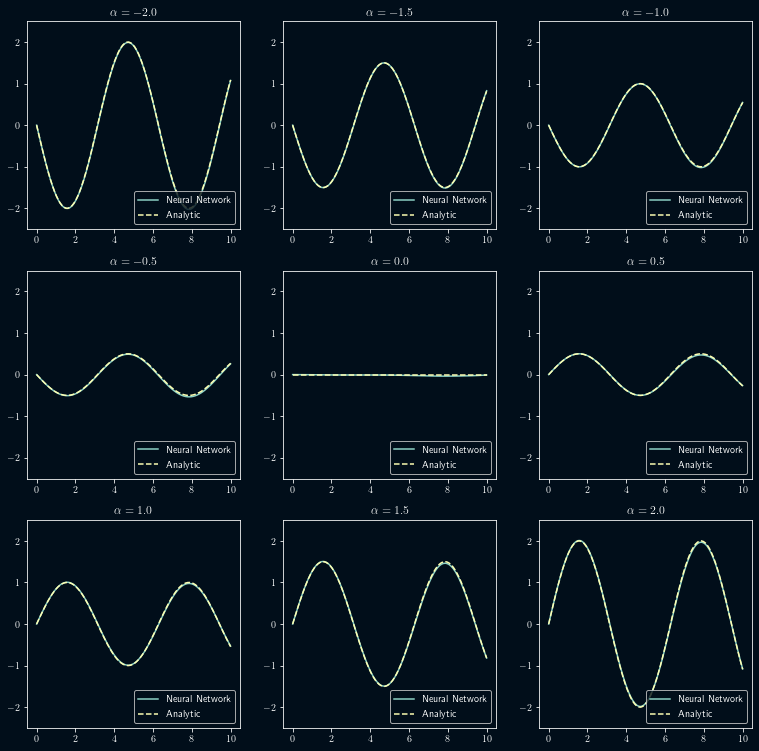

In [10]:
#collapse
t = np.linspace(0, 10, 100)
alphas = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
nn_sols = np.zeros((len(t), len(alphas)))

for j, alpha in enumerate(alphas):
    alpha_vec = alpha*np.ones(len(t))
    inputs = np.stack([t, alpha_vec]).T     
    nn_sol = dg.solve(inputs)[:,0]
    nn_sols[:,j] = nn_sol

fig, axs = plt.subplots(3, 3, figsize=(13,13))
for j, ax in enumerate(fig.axes):
    analytic_sol = alphas[j]*np.sin(t)
    ax.plot(t, nn_sols[:,j], label="Neural Network")
    ax.plot(t, analytic_sol, label="Analytic", linestyle="--")
    ax.set_title(r"$\alpha = {}$".format(alphas[j]))
    ax.legend(loc="lower right")
    ax.set_ylim(-2.5, 2.5)

plt.show()

Another feature of this approach is that we can get the gradient of the solution with respect to the parameters $\theta$ *for free* (virtually). We can calculate the gradient by using automatic differentiation, the same tool that is being used to train the neural network in the first place. If you're familiar with PyMC3, this is also the tool being used under-the-hood to get the gradients for use in the NUTS sampler. For any $t$ the analytic gradient of our ODE solution is
$$
\nabla_\theta \, x(t) =  \cfrac{\partial x(t)}{\partial \alpha} = \sin(t).
$$
Let's compare this to the gradients we get from querying our neural network.

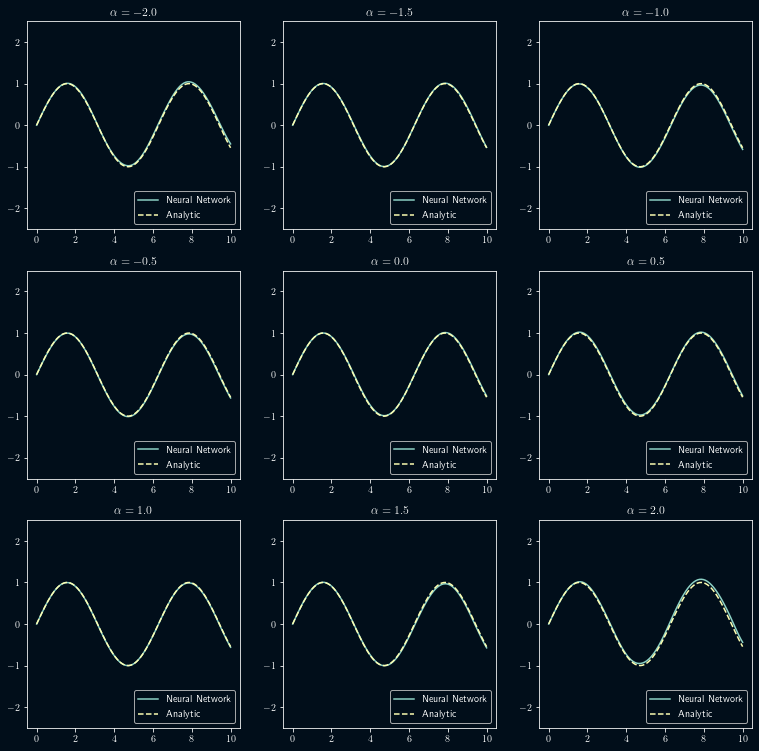

In [11]:
#collapse
t = np.linspace(0, 10, 100)
alphas = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
nn_sols = np.zeros((len(t), len(alphas)))

for j, alpha in enumerate(alphas):
    alpha_vec = alpha*np.ones(len(t))
    inputs = np.stack([t, alpha_vec]).T    
    nn_sol = dg.solve(inputs, fetches="dxdalpha")[:,0]
    nn_sols[:,j] = nn_sol

fig, axs = plt.subplots(3, 3, figsize=(13,13))
for j, ax in enumerate(fig.axes):
    analytic_sol = np.sin(t)
    ax.plot(t, nn_sols[:,j], label="Neural Network")
    ax.plot(t, analytic_sol, label="Analytic", linestyle="--")
    ax.set_title(r"$\alpha = {}$".format(alphas[j]))
    ax.legend(loc="lower right")
    ax.set_ylim(-2.5, 2.5)

plt.show()

Now that we have a neural network that can solve our ODE and compute gradients, we have everything we need to perform inference with the model.

# Integrating PyMC3

We'll consider the simple inference problem of estimating $\alpha$ given a sequence of noisy observations $y_i$ of $x(t)$, i.e.
$$
\begin{align}
\cfrac{dx}{dt} &= \alpha \cos(t), \\
x(0) &= 0, \\
y_i &= x(t_i) + \varepsilon, \\
\varepsilon &\sim \mathcal{N}(0, \sigma^2),
\end{align}
$$
for some level of noise $\sigma > 0$. First let's generate some artifical data.

In [12]:
# Set true values of the unknown parameters
alpha_true = 1.3
sigma_true = 3.0

# Make fake data
np.random.seed(0)
dts = 0.2*np.abs(np.random.randn(50))
t_obs = dts.cumsum()
x_obs = alpha_true*np.sin(t_obs)
y_obs = x_obs + sigma_true*np.random.randn(len(x_obs))

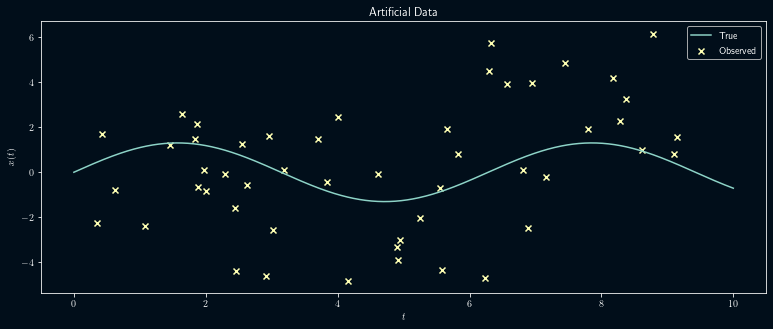

In [13]:
#collapse

t = np.linspace(0, 10, 1000)
x = alpha_true*np.sin(t)

fig, axs = plt.subplots(figsize=(13,5))

axs.plot(t, x, label="True")
axs.scatter(t_obs, y_obs, label="Observed", color="C1", marker="x")
axs.set_xlabel(r"$t$")
axs.set_ylabel(r"$x(t)$")
axs.set_title("Artificial Data")
axs.legend()

plt.show()

In order to use our neural network with PyMC3 we'll write our own Theano `Op` that takes care of connecting it to the computational graph of a PyMC3 model.

In [14]:
import theano
import theano.tensor as tt
from theano import Op


class ODEop(Op):
    
    itypes = [tt.dscalar] # expects a vector of parameter values when called
    otypes = [tt.dvector] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, diffeq_model, t_points):
        self.diffeq_model = diffeq_model
        self.t_points = t_points
        self.n_points = len(self.t_points)
        #print(self.n_points)
        
    def perform(self, node, inputs, outputs):
        
        epsilon, = inputs
        #print(epsilon.shape)
        pts = np.concatenate([self.t_points.reshape(-1, 1), epsilon * np.ones((self.n_points, 1))], axis=1)
        result = np.float64(np.squeeze(self.diffeq_model.solve(pts)))
        
        outputs[0][0] = result
        
    
    def grad(self, inputs, g):
        epsilon, = inputs
        #Epsilon = self(epsilon)
        #print(epsilon.shape)
        pts = np.concatenate([self.t_points.reshape(-1, 1), epsilon * tt.ones_like(np.ones((self.n_points, 1)))], axis=1)
        result = np.float64(np.squeeze(self.diffeq_model.solve(pts, fetches="d_epsilon")))
        print(result)
        print(g*result)

        return [ g[0]*result ]
        















# class ODEGradop(Op):

#     itypes = [tt.dscalar, tt.dvector]
#     otypes = [tt.dscalar]

#     def __init__(self, pydens_model, t_obs):
#         self.pydens_model = pydens_model

#         # Setup the input for the neural net
#         t_comp = np.stack([t_obs, np.zeros_like(t_obs)]).T
#         alpha_comp = np.stack([np.zeros_like(t_obs), np.ones_like(t_obs)]).T
#         self.t_comp = theano.tensor.as_tensor_variable(t_comp)
#         self.alpha_comp = theano.tensor.as_tensor_variable(alpha_comp)


#     def perform(self, node, inputs, outputs):
#         #print("GradOp perform() triggered")
#         alpha, g  = inputs
#         nn_input = self.t_comp + alpha*self.alpha_comp
#         result = np.float64(self.pydens_model.solve(nn_input.eval(), fetches="dxdalpha")[:,0])
#         #print(result)
#         outputs[0][0] = np.dot(g, result)



# class ODEop(Op):

#     itypes = [tt.dscalar]
#     otypes = [tt.dvector]

#     def __init__(self, pydens_model, t_obs):
#         self.pydens_model = pydens_model
#         self.t_obs = t_obs
        
#         # Setup the input for the neural net
#         t_comp = np.stack([t_obs, np.zeros_like(t_obs)]).T
#         alpha_comp = np.stack([np.zeros_like(t_obs), np.ones_like(t_obs)]).T
#         self.t_comp = theano.tensor.as_tensor_variable(t_comp)
#         self.alpha_comp = theano.tensor.as_tensor_variable(alpha_comp)


#     def perform(self, node, inputs, outputs):
#         #print("Op perform() triggered")
#         alpha, = inputs
#         nn_input = self.t_comp + alpha*self.alpha_comp
#         result = np.float64(self.pydens_model.solve(nn_input.eval())[:,0])
#         #print("Op perform: ", result)
#         outputs[0][0] = result

#     def grad(self, inputs, output_grads):
#         #print("Op grad() triggered")
#         alpha, = inputs
#         g, = output_grads

#         grad_op = ODEGradop(self.pydens_model, self.t_obs)
#         #print(alpha.type())
#         #print(g.type())
#         grad_op_apply = grad_op(alpha, g)

#         return [grad_op_apply]

        # _ = self(alpha)
        # nn_input = self.t_comp + alpha*self.alpha_comp
        # gr

        # return [output_grads*out]
        # #out = self.pydens_model.solve(nn_input.eval(), fetchs="dxdalpha")[:,0]
        
        
        # return [output_grads*out]
        #g = output_grads[0]
        #grad_op = ODEGradop(self.pydens_model, self.t_obs)
        #grad_op_apply = grad_op(alpha, g)
        #return [g*grad_op_apply]
        

In [15]:
import pymc3 as pm

In [16]:
tt_PyDEnsModel = ODEop(dg, t_obs)

with pm.Model() as model:
    # Priors
    alpha = pm.Uniform("alpha", lower=-2.0, upper=2.0)
    sigma = pm.Uniform("sigma", lower=0.3, upper=6.0)
    
    # ODE
    ode_sol = tt_PyDEnsModel(alpha)
    forward = ode_sol.reshape(y_obs.shape)

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=forward, sigma=sigma, observed=y_obs)

In [17]:
with model:
    trace = pm.sample(cores=1, chains=1, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [alpha]
>NUTS: [sigma]


Sampling 1 chain for 1_000 tune and 565 draw iterations (1_000 + 565 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [29]:
import arviz as az

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

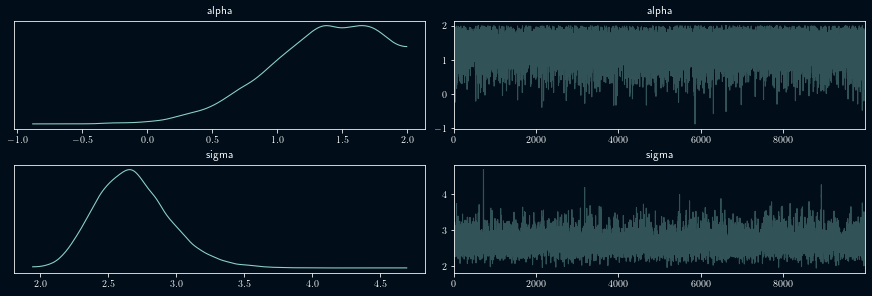

In [37]:
az.plot_trace(trace)

<AxesSubplot:xlabel='alpha', ylabel='sigma'>

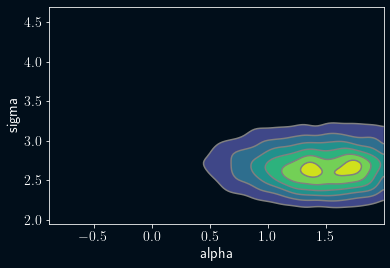

In [43]:
az.plot_pair(trace, kind="kde")

In [38]:
with pm.Model() as analytic_model:
    # Priors
    alpha = pm.Uniform("alpha", lower=-2.0, upper=2.0)
    sigma = pm.Uniform("sigma", lower=0.3, upper=6.0)
    
    # ODE
    forward = pm.Deterministic("forward", alpha*tt.sin(t_obs))

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=forward, sigma=sigma, observed=y_obs)

In [39]:
with analytic_model:
    trace_analytic = pm.sample(cores=1, chains=1, draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, alpha]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

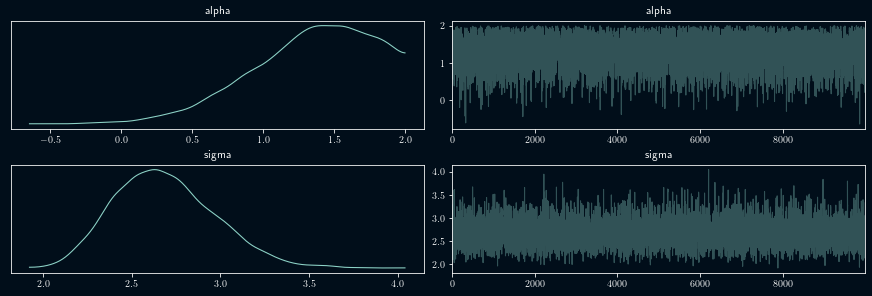

In [40]:
az.plot_trace(trace_analytic, var_names=["~forward"])

<AxesSubplot:xlabel='alpha', ylabel='sigma'>

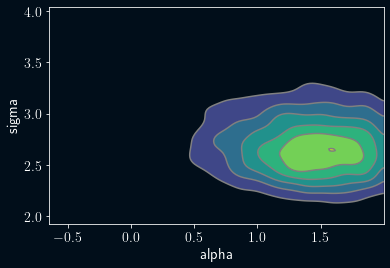

In [42]:
az.plot_pair(trace_analytic, kind="kde", var_names=["~forward"])

In [ ]:
# class ODEop(Op):
    
#     itypes = [tt.dscalar] # expects a vector of parameter values when called
#     otypes = [tt.dvector] # outputs a single scalar value (the log likelihood)
    
#     def __init__(self, diffeq_model, t_points):
#         self.diffeq_model = diffeq_model
#         self.t_points = t_points
#         self.n_points = len(self.t_points)

#         self.logpgrad = 
#         print(self.n_points)
        
#     def perform(self, node, inputs, outputs):
        
#         alpha, = inputs
#         #print(epsilon.shape)
#         #alpha_vec = alpha*np.ones(len(t))
#         #inputs = np.stack([t, alpha_vec]).T 
#         #pts = np.concatenate()
#         pts = np.concatenate([t_points.reshape(-1, 1), alpha * np.ones((self.n_points, 1))], axis=1)
#         result = np.float64(np.squeeze(self.diffeq_model.solve(pts)))
        
#         outputs[0][0] = result
        
    
#     def grad(self, inputs, g):
#         alpha, = inputs
#         Epsilon = self(epsilon)
#         print(epsilon.shape)
#         pts = np.concatenate([t_points.reshape(-1, 1), epsilon * tt.ones_like(np.ones((self.n_points, 1)))], axis=1)
#         result = np.float64(np.squeeze(self.diffeq_model.solve(pts, fetches="dxdalpha")))
        
#         return [ g*result ]

# I don't think I'm going to keep this example

Given the recent pandemic, you may have heard of the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) for infectious diseases. The SIR model is given by 
$$
\begin{align}
\cfrac{dS}{dt} &= -\beta I S \\
\cfrac{dI}{dt} &= \beta I S - \gamma I \\
\cfrac{dR}{dt} &= \gamma I \\
\end{align}
$$
where $\beta, \gamma > 0$. We can show that $S(t) + I(t) + R(t) = 1$, which means we actually can just look at 
$$
\begin{align}
\cfrac{dS}{dt} &= -\beta I S \\
\cfrac{dI}{dt} &= \beta I S - \gamma I \\
\end{align}
$$
and then recover $R(t)$ as $R(t) = 1 - S(t) - I(t)$. Let's fix 
$$
\begin{align}
\beta &= 0.1, &S(0) &= 0.95, \\
\gamma &= 0.05, &I(0) &= 0.05,
\end{align}
$$
and use `scipy.integrate.odeint` to approximate the solution.

In [211]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl

def sir_model(y, t, beta, gamma):
    S, I = y
    dSdt = -beta*I*S
    dIdt = beta*I*S - gamma*I
    return [dSdt, dIdt]

t = np.linspace(0, 250, 1000)
y0 = [0.95, 0.05]
beta, gamma = 0.1, 0.05
sp_sol = odeint(sir_model, y0, t, args=(beta, gamma))

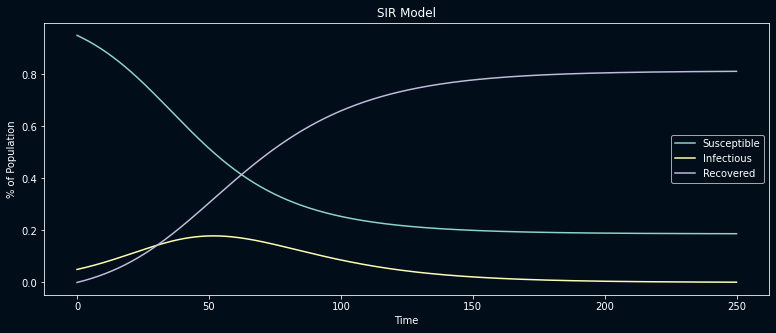

In [212]:
#collapse
S, I = sp_sol.T
R = 1.0 - S - I

fig, axs = plt.subplots(figsize=(13,5))
axs.plot(t, S, label="Susceptible")
axs.plot(t, I, label="Infectious")
axs.plot(t, R, label="Recovered")
axs.set_xlabel("Time")
axs.set_ylabel("% of Population")
axs.set_title("SIR Model")
axs.legend()
plt.show()

Ignoring the specifics for now, let's use PyDEns to train a neural network that solves the same equation ODE as above.

In [ ]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tqdm import tqdm_notebook

import tensorflow as tf
from pydens import Solver, NumpySampler, cart_prod, add_tokens
from pydens import plot_loss, plot_pair_1d, plot_2d, plot_sections_2d, plot_sections_3d

add_tokens()

In [15]:
ode = {
    'n_dims': 1,
    'n_funs': 2,
    'n_eqns': 2,
    'form': [
        lambda S, I, t: D(S, t) + beta*S*I,
        lambda S, I, t: D(I, t) - beta*S*I + gamma*I
    ],
    'initial_condition': [[0.95],[0.05]],
    'time_multiplier': 'polynomial',
    # 'bind_bc_ic': True
}

config = {
    'pde': ode,
    #'optimizer': 'Adam'
    # 'decay': {'name': 'cyclic', 'learning_rate':0.001,
    #           'max_lr': 0.01, 'step_size': 500},
    # 'decay': {'name': 'invtime', 'learning_rate':0.01,
    #           'decay_steps': 100, 'decay_rate': 0.05},
    # 'track': {'dt': lambda u, t, e: D(u, t),
    #          'd_epsilon': lambda u, t, e : D(u, e)}
}

#sampler = NumpySampler('uniform', dim=1, low=0.0, high=30.0)

dg = Solver(config)


sampler = NumpySampler('uniform', dim=1, low=0.0, high=250.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

NameError: name 'beta' is not defined

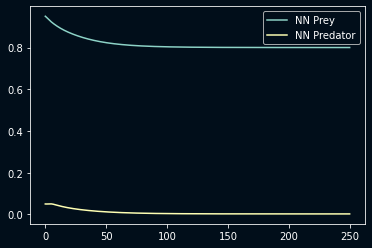

In [214]:
t_reshaped = t[:, None]
nn_sol = dg.solve(t_reshaped)

plt.plot(t, nn_sol[:,0], label="Susceptible")
plt.plot(t, nn_sol[:,1], label="Infectious")
# plt.plot(t, prey, label="SP Prey")
# plt.plot(t, predator, label="SP Predator")
# plt.title("Predator Error")
plt.legend()
plt.show()

# Note: Save this example for later. This is tricky because of the nullclines.
Let's take a look at the [Lotka-Volterra predator prey model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), since this also appears in [this example PyMC3 notebook](https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_with_manual_gradients.html) and will be useful for comparison later. The Lotka-Volterra model is given by
$$ 
\begin{align}
      \cfrac{dx}{dt} &= \alpha x - \beta x y \\
      \cfrac{dy}{dt} &= -\gamma y + \delta xy 
\end{align}
$$
where $\alpha, \beta, \gamma, \delta > 0$. Here $y(t)$ and $x(t)$ represent the population level of some predator and prey in some ecosystem, respectively. Let's generate some synthetic data with [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) using $x(0) = 30$ and $y(0) = 50$ as our initial conditions and fixing
$$
\begin{align}
\alpha_{\text{true}} &= 0.5 \\
\beta_{\text{true}} &= 0.025 \\
\gamma_{\text{true}} &= 0.8 \\
\delta_{\text{true}} &= 0.025 \\
\end{align}
$$

In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl

def lotka_volterra(y, t, alpha, beta, gamma, delta):
    prey, predator = y
    dpreydt = alpha*prey - beta*prey*predator
    dpredatordt = -gamma*predator + delta*prey*predator
    return [dpreydt, dpredatordt]

t = np.linspace(0, 30, 1000)
y0 = [30, 50]
alpha, beta, gamma, delta = 0.5, 0.025, 0.8, 0.025
sp_sol = odeint(lotka_volterra, y0, t, args=(alpha, beta, gamma, delta))

In [19]:
#hide
plt.style.use('dark_background')
mpl.rcParams['axes.facecolor'] = '#010E1A'
mpl.rcParams['figure.facecolor'] = '#010E1A'
mpl.rcParams['figure.edgecolor'] = '#010E1A'

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

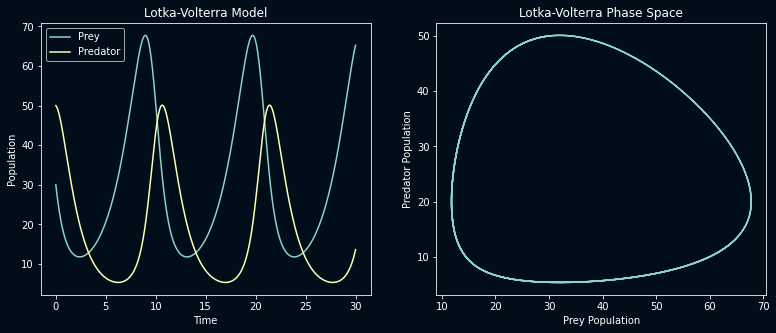

In [20]:
#collapse

fig, axs = plt.subplots(1,2, figsize=(13,5))

prey, predator = sp_sol.T

axs[0].plot(t, prey, label="Prey")
axs[0].plot(t, predator, label="Predator")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Population")
axs[0].set_title("Lotka-Volterra Model")
axs[0].legend()


axs[1].plot(prey, predator)
axs[1].set_xlabel("Prey Population")
axs[1].set_ylabel("Predator Population")
axs[1].set_title("Lotka-Volterra Phase Space")

plt.show()

Ignoring the specifics of what's going on down below for now, let's use `PyDEns` to train a neural network that solves the same ODE as above.

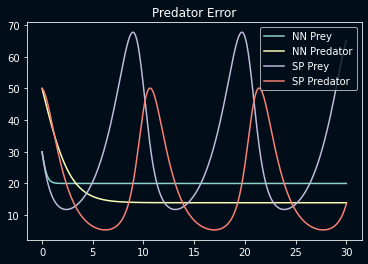

In [21]:
# import os
# import sys
# import warnings
# warnings.filterwarnings('ignore')
# from tensorflow import logging
# logging.set_verbosity(logging.ERROR)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# from tqdm import tqdm_notebook

# import tensorflow as tf
# from pydens import Solver, NumpySampler, cart_prod, add_tokens
# from pydens import plot_loss, plot_pair_1d, plot_2d, plot_sections_2d, plot_sections_3d

# add_tokens()

# ode = {
#     'n_dims': 1,
#     'n_funs': 2,
#     'n_eqns': 2,
#     'form': [
#         lambda x, y, t: D(x, t) - (30/100)*(alpha*(100*x) + beta*(100*x)*(100*y)),
#         lambda x, y, t: D(y, t) + (30/100)*(gamma*(100*y) - delta*(100*x)*(100*y))
#     ],
#     'initial_condition': [[30/100],[50/100]],
#     #'time_multiplier': 'sigmoid',
#     # 'bind_bc_ic': True
# }

ode = {
    'n_dims': 1,
    'n_funs': 2,
    'n_eqns': 2,
    'form': [
        lambda x, y, t: D(x, t) - alpha*x + beta*x*y,
        lambda x, y, t: D(y, t) + gamma*y - delta*x*y
    ],
    'initial_condition': [[30],[50]],
    #'time_multiplier': 'sigmoid',
    # 'bind_bc_ic': True
}

config = {
    'pde': ode,
    #'optimizer': 'Adam'
    # 'decay': {'name': 'cyclic', 'learning_rate':0.001,
    #           'max_lr': 0.01, 'step_size': 500},
    # 'decay': {'name': 'invtime', 'learning_rate':0.01,
    #           'decay_steps': 100, 'decay_rate': 0.05},
    # 'track': {'dt': lambda u, t, e: D(u, t),
    #          'd_epsilon': lambda u, t, e : D(u, e)}
}

#sampler = NumpySampler('uniform', dim=1, low=0.0, high=30.0)

dg = Solver(config)


sampler = NumpySampler('uniform', dim=1, low=0.0, high=10.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

# dtm = 5.0
# tms = np.arange(1.0, 30.0+dtm, dtm)
# n_iter_per_tm = 10000
# for j, tm in enumerate(tms):
#     sampler = NumpySampler('uniform', dim=1, low=0.0, high=tm)
#     dg.fit(batch_size=50, sampler=sampler, n_iters=(j+1)*n_iter_per_tm, bar='notebook')

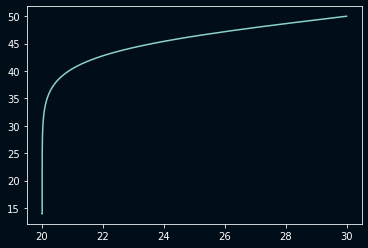

In [22]:
plt.plot(res[:,0], res[:,1], label="NN Prey")

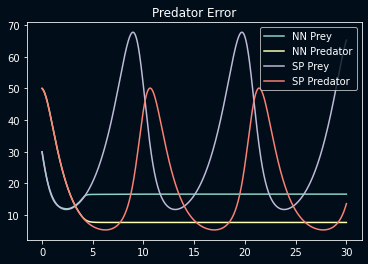

In [186]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=4.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

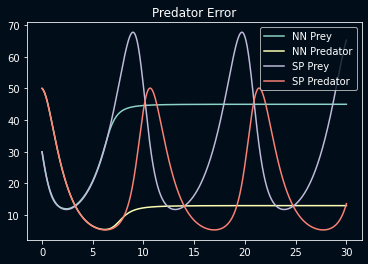

In [187]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=6.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

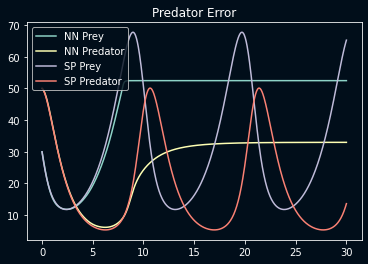

In [188]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=8.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

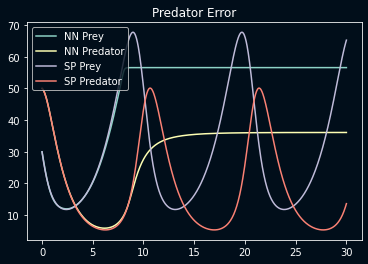

In [189]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=8.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

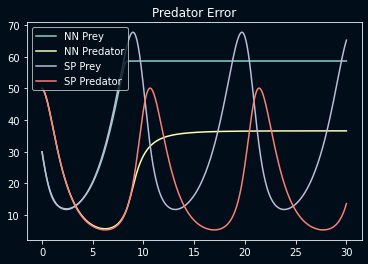

In [190]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=8.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

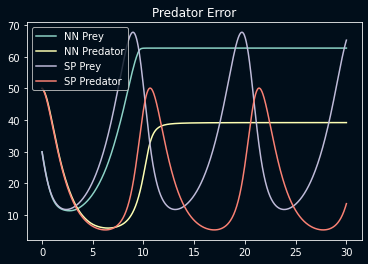

In [191]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=10.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

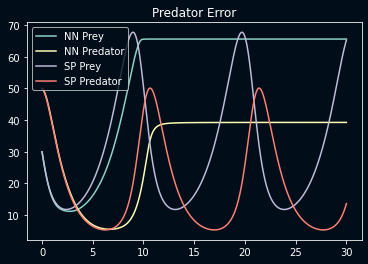

In [192]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=10.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

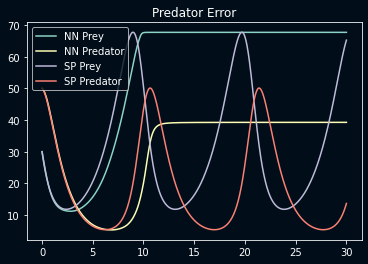

In [194]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=10.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

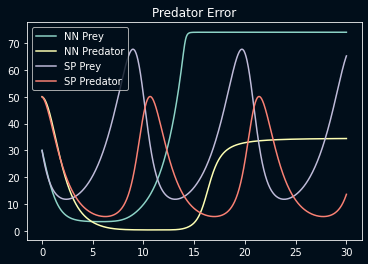

In [196]:
sampler = NumpySampler('uniform', dim=1, low=0.0, high=14.0)
dg.fit(batch_size=50, sampler=sampler, n_iters=10000)

t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

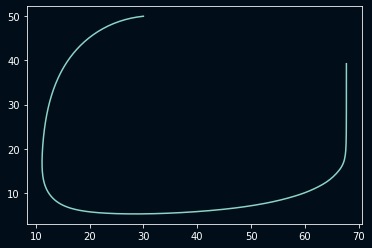

In [195]:
plt.plot(res[:,0], res[:,1], label="NN Prey")
plt.show()

It looks like that did something exciting! Let's look at how our loss function evolved as the network was trained.

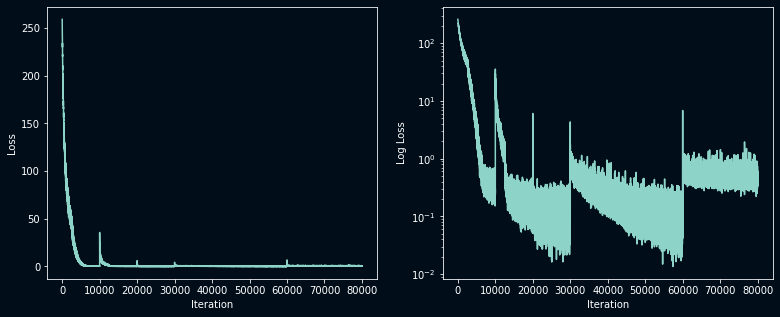

In [193]:
# collapse

n_iters = len(dg.loss)
it_idx = [i+1 for i in range(n_iters)]

fig, axs = plt.subplots(1, 2, figsize=(13,5))

axs[0].plot(it_idx, dg.loss)
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Iteration')

axs[1].plot(it_idx, dg.loss)
axs[1].set_ylabel('Log Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_yscale('log')

plt.show()

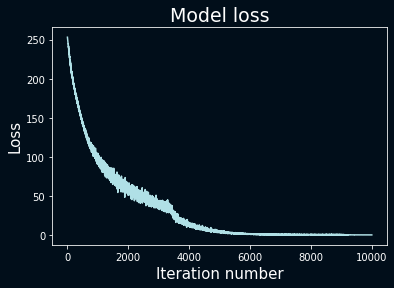

In [171]:
plot_loss(dg.loss)

Now that we have our trained neural network, let's compare its estimated solution with the solution we got earlier from `scipy.integrate.odeint`.

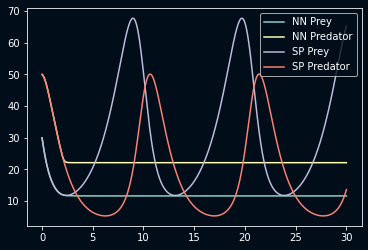

In [173]:
t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, res[:,0], label="NN Prey")
plt.plot(t, res[:,1], label="NN Predator")
plt.plot(t, prey, label="SP Prey")
plt.plot(t, predator, label="SP Predator")
plt.title("Predator Error")
plt.legend()

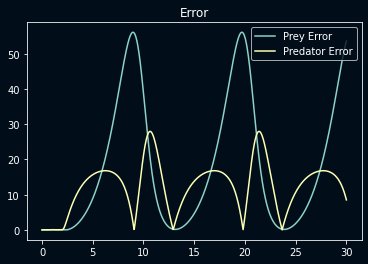

In [176]:
t_reshaped = t[:, None]
res = dg.solve(t_reshaped)

plt.plot(t, np.abs(prey - res[:,0]), label="Prey Error")
plt.plot(t, np.abs(predator - res[:,1]), label="Predator Error")
plt.title("Error")
plt.legend()
plt.show()

In [ ]:
def check_if_stable(loss, lookback_its = ):
    """Checks if the loss curve has flattened out.
    """

In [163]:
np.mean(np.diff(dg.loss))

-0.0008927509

Now suppose that the observed data we see in reality is some sparsely-observed subset of this data, contaminated by some Gaussian noise with mean zero and variance $\sigma^2_{\text{true}} = 100.0$. Let's take a subset of the points from above and add on this noise.

In [51]:
# Get every 50th point
t_idxs = np.arange(0, 1000, 50)
t_obs = t[t_idxs]
prey_obs, predator_obs = sol[t_idxs, :].T

# Add on noise
sigma_true = 10.0
prey_obs += sigma_true*np.random.randn(len(prey_obs))
predator_obs += sigma_true*np.random.randn(len(predator_obs))


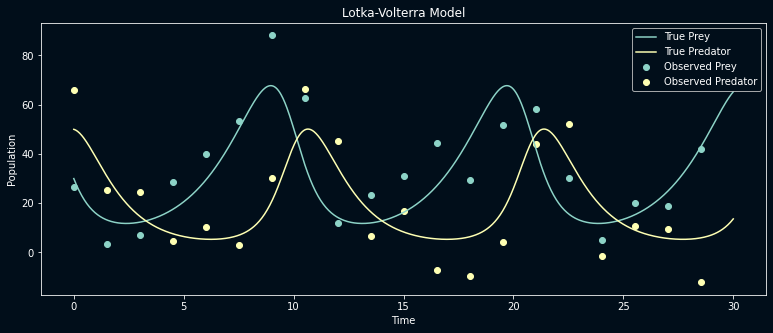

In [52]:
#collapse

fig, axs = plt.subplots(figsize=(13,5))

axs.plot(t, prey, label="True Prey")
axs.plot(t, predator, label="True Predator")
axs.scatter(t_obs, prey_obs, label="Observed Prey")
axs.scatter(t_obs, predator_obs, label="Observed Predator")
axs.set_xlabel("Time")
axs.set_ylabel("Population")
axs.set_title("Lotka-Volterra Model")
axs.legend()


plt.show()

array([ 0.        ,  1.5015015 ,  3.003003  ,  4.5045045 ,  6.00600601,
        7.50750751,  9.00900901, 10.51051051, 12.01201201, 13.51351351,
       15.01501502, 16.51651652, 18.01801802, 19.51951952, 21.02102102,
       22.52252252, 24.02402402, 25.52552553, 27.02702703, 28.52852853])

# Some sources
http://mattpitkin.github.io/samplers-demo/pages/pymc3-blackbox-likelihood/